# Energy Data Science Experiment


# Motivation

Being able to accurately forecast the volatile demand for power, especially across low-voltage distribution grids, is increasingly important to providing sufficent energy supply. Paradoxically, it's at the low-voltage networks that are the most volatile, and yet the most critical to account for as more distributed energy resources (e.g., solar, storage) make their way onto the grid. From the grid operator's point of view, not only are lower voltage service points (e.g., customers) the revenue life blood of the business, having increased visibility into demand at such lower levels of aggregation helps to provide 


In this notebook, I explore looking at a Kaggle data set containing about 5,000 utility service points with time series data from advanced metering infrastructure (AMI). The context of this experiment is to simulate the needs of a utility or grid operator and generate accurate short-term (up to 7 days ahead) forecast. I explore possible approaches that involve

- *Feature-based modeling approaches*
- *Customer Segmentation + Clustering*
- *Statistical methods, ML methods, and hybrid cross-learning approaches*

Performance is evaluated using time-series cross-validation using a rolling 7-day forecast horizon.

Finally, I show how this solution might be scaled and put into production.

Keywords: *time series classification*, *energy forecasting*, *cross-learning*, *MLOps*


In [1]:
# Import Dependencies

### Utilities ###

import os
import glob
from tqdm import tqdm

### Data Processing ###

import numpy as np
import pandas as pd
from datetime import datetime

### PLOTTING ###

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)

import seaborn as sns


### DATA SCIENCE ###

#import lightgbm as lgb
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV,KFold,RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint
import random
from functools import reduce

import tsfeatures as tsfeatures


Using TensorFlow backend.


In [2]:
# Set Project Working Directory
project_path = '/workspace/portfolio'

#os.getcwd()
os.chdir(project_path)

#os.environ
#pd.set_option('display.max_columns', None)

data_path = f"{project_path}/data"
data_path
 
# Read in Secure Credentials from Local File
#with open('cred.json') as f:
#  cred = json.load(f)

# Set AWS Credentials
#os.environ["AWS_ACCESS_KEY_ID"] = cred['aws'].get("AWS_ACCESS_KEY_ID")
#os.environ["AWS_SECRET_ACCESS_KEY"] = cred['aws'].get("AWS_SECRET_ACCESS_KEY")

# Set Twillio Credentials
#os.environ["TWILIO_SID"] = cred['twilio'].get("cred1")
#os.environ["TWILIO_TOKEN"] = cred['twilio'].get("cred2")
#os.environ


'/workspace/portfolio/data'

In [3]:
os.getcwd()


'/workspace/portfolio'

In [4]:
# need kaggle api key, stored in .kaggle/kaggle.json
# kaggle datasets download -d jeanmidev/smart-meters-in-london


In [5]:
# Data 

#https://www.kaggle.com/jeanmidev/smart-meters-in-london

#hh = pd.read_csv(data_path + "halfhourly_dataset")
all_files = os.listdir(data_path + "/hhblock_dataset/hhblock_dataset/")

df_from_each_file = (pd.read_csv(data_path + "/hhblock_dataset/hhblock_dataset/" + f, sep=',') for f in all_files)
df_merged   = pd.concat(df_from_each_file, ignore_index=True)


In [6]:
df_merged.head()

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000013,2012-06-22,0.127,0.113,0.076,0.109,0.120,0.096,0.113,0.148,...,0.086,0.154,0.121,0.102,0.131,0.121,0.082,0.096,0.127,0.126
1,MAC000013,2012-06-23,0.106,0.135,0.228,0.079,0.109,0.117,0.079,0.122,...,0.107,0.113,0.106,0.077,0.119,0.126,0.151,0.135,0.108,0.093
2,MAC000013,2012-06-25,0.099,0.119,0.169,0.136,0.109,0.090,0.132,0.131,...,0.140,0.135,0.134,0.106,0.131,0.169,0.170,0.141,0.163,0.137
3,MAC000013,2012-06-26,0.142,0.103,0.117,0.136,0.127,0.129,0.150,0.137,...,0.136,0.136,0.304,0.159,0.126,0.145,0.196,0.158,0.173,0.149
4,MAC000013,2012-06-27,0.126,0.128,0.175,0.163,0.119,0.103,0.128,0.141,...,0.170,0.144,0.098,0.183,0.316,0.190,0.121,0.176,0.158,0.146


In [7]:
print(df_merged.shape)
print(df_merged.describe)

(3469352, 50)
<bound method NDFrame.describe of              LCLid         day   hh_0   hh_1   hh_2   hh_3   hh_4   hh_5  \
0        MAC000013  2012-06-22  0.127  0.113  0.076  0.109  0.120  0.096   
1        MAC000013  2012-06-23  0.106  0.135  0.228  0.079  0.109  0.117   
2        MAC000013  2012-06-25  0.099  0.119  0.169  0.136  0.109  0.090   
3        MAC000013  2012-06-26  0.142  0.103  0.117  0.136  0.127  0.129   
4        MAC000013  2012-06-27  0.126  0.128  0.175  0.163  0.119  0.103   
...            ...         ...    ...    ...    ...    ...    ...    ...   
3469347  MAC005387  2014-02-23  0.686  0.070  0.145  0.056  0.035  0.034   
3469348  MAC005387  2014-02-24  0.137  0.107  0.086  0.044  0.042  0.058   
3469349  MAC005387  2014-02-25  0.116  0.135  0.048  0.046  0.074  0.096   
3469350  MAC005387  2014-02-26  0.113  0.051  0.042  0.083  0.077  0.037   
3469351  MAC005387  2014-02-27  0.044  0.038  0.046  0.095  0.044  0.035   

          hh_6   hh_7  ...  hh_38  hh_3

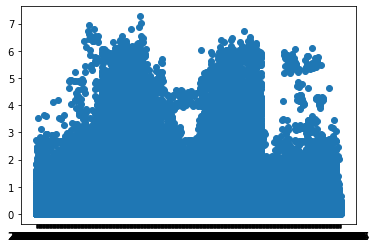

In [8]:
fig, ax = plt.subplots()
ax.scatter(df_merged["day"], df_merged["hh_0"])


In [ ]:
#df = df_merged[df_merged['LCLid'] == 'MAC000027']
#df.head()

## Tranpose from wide to long

df = pd.wide_to_long(df_merged, stubnames = "hh_", i = ['day', 'LCLid'], j = "hh").sort_values(["day", "hh"]).reset_index()

#df.columns.values
#df.shape

#ax.plot(df0["hh_"])
fig, ax = plt.subplots()
ax.plot(df["hh"], df["hh_"])


In [ ]:
# import time lookup
lookup = pd.read_csv(data_path + "/time-lookup.csv", sep = ",")
lookup.head()

In [ ]:
df = df.sort_values(["LCLid", "day", "hh"])
df = df.join(lookup.set_index("hh"), how = "left", on = "hh")
df.head()

In [ ]:
df["timestamp"] = pd.to_
datetime(df['day'] + " " + df['time'])

In [ ]:
print(df.shape)
print(df.head())

In [ ]:
df = df.drop(["day", "hh", "time"], axis = 1)
df.head()

In [ ]:
df.columns = ["id", "kwh", "timestamp"]
df.head()

In [ ]:
df_wide = df.pivot(index = "timestamp", columns = 'id', values = 'kwh')

df_wide.head()

In [ ]:
df_wide = df_wide.to_numpy()
df_wide[np.isnan(df_wide)] = 0

In [ ]:
print(df_wide.shape)
print(np.transpose(df_wide).shape)

In [ ]:
series = np.transpose(df_wide)
X_train, y_train = series[:4500, :39695], series[:4500, -1]
X_valid, y_valid = series[4500:5000, :39695], series[4500:5000, -1]
X_test, y_test = series[5000:, :39695], series[5000:, -1]

In [ ]:
X_train, y_train = X_train[~np.isnan(X_train)], y_train[~np.isnan(y_train)]
X_valid, y_valid = X_valid[~np.isnan(X_valid)], y_valid[~np.isnan(y_valid)]
X_test, y_test = X_test[~np.isnan(X_test)], y_test[~np.isnan(y_test)]

In [ ]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid[~np.isnan(y_valid)], y_pred[~np.isnan(y_pred)]))

In [ ]:
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[39695, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

In [ ]:
model.evaluate(X_valid, y_valid)

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 100, 0, 30])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

In [ ]:
# Unique Number of Sensor meters
ids = pd.DataFrame(df_merged['LCLid'].unique()).sample(n = 1000)
ids.columns = ['id']

df = df.loc[df['LCLid'].isin(ids["id"])]
df.head()


In [ ]:
#df = df_merged[df_merged['LCLid'] == 'MAC000027']
#df.head()

df0 = pd.wide_to_long(df_merged, stubnames = "hh_", i = ['day', 'LCLid'], j = "hh").sort_values(["day", "hh"])
df = df0.reset_index()

#df.columns.values
df.shape

#ax.plot(df0["hh_"])
#fig, ax = plt.subplots()
#ax.scatter(df["hh"], df["hh_"])

In [ ]:
df_wide = df.pivot(index = "timestamp", columns = 'id', values = 'usage')

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]




In [ ]:
##############################
### User Defined Functions ###
##############################

# Define a function to recursively flatten JSON object
def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

# Define a function to process each JSON record
def process_row(x):
    input_json = json.loads(x)
    flat_json = flatten_json(input_json)
    flat_df = pd.DataFrame.from_dict(flat_json, orient = "index").T
    return flat_df

# Define a function process an entire file
def process_file(filename, destination = "data/processed/"):
	df = pd.read_excel(filename)

	# Extract Participant ID
	pid = df.participant_id.iloc[0]

	# Split data based on data category
	ops_data = df[df['data_category'] == 'Operational']
	conf_data = df[df['data_category'] == 'Configuration']

	# Use List Comprehension to apply function to each row
	list_output = [process_row(x) for x in tqdm(ops_data['hvac'])]

	# Concatenate list output to produce data frame
	df_output = pd.concat(list_output, ignore_index = True)

	# Concatenate Processed JSON with IDs
	output = pd.concat((ops_data.drop(['hvac'], axis = 1).reset_index(), df_output), axis=1)

	# Establish Output File Name
	output_file_name = destination + pid + '-ops.csv'

	# Writeout operational data
	output.to_csv(output_file_name)

	# Use List Comprehension to apply function to each row
	list_output = [process_row(x) for x in tqdm(conf_data['hvac'])]

	# Concatenate list output to produce data frame
	df_output = pd.concat(list_output, ignore_index = True)

	# Concatenate Processed JSON with IDs
	output = pd.concat((conf_data.drop(['hvac'], axis = 1).reset_index(), df_output), axis=1)

	# Establish Output File Name
	output_file_name = destination + pid + '-config.csv'

	# Writeout configuration data data
	output.to_csv(output_file_name)


# list files in current directory
directory = os.getcwd()

# iterate over files in current directory and process them

for filename in os.listdir(directory):
    if filename.endswith(".xlsx"):
        try:
        	print("Processing File: " + filename)
        	process_file(filename, destination = "/Users/jonfarland/Documents/projects/APC/data/processed/")
        except:
        	print("Error Processing File: " + filename)
    else:
        continue
